In [1]:
import torch
import torchvision.datasets as dsets
import numpy as np
import time

# Hyper Parameters
layerDimensions = [784, 128, 64, 10]
num_epochs = 5
batch_size = 100
learningRate = 0.01
numberOfLabels = 10

# MNIST Dataset
train_dataset = dsets.MNIST(root='./data/',
                            train=True,
                            download=True)

test_dataset = dsets.MNIST(root='./data/',
                           train=False,
                           download=True)

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)


# We have 5 epochs of 100 of pictures each one
# and each picture's size is 28x28

In [2]:
class NN():
    ### Initialize the neural network
    def __init__(self, layerDimensions, epochs, learningRate):
        self.accuracy = []
        self.layerDimensions = layerDimensions
        self.epochs = epochs
        self.learningRate = learningRate
        self.parameters = {}

        ### Initializes randoms weights and biases parameters
        L = len(layerDimensions)
        for i in range(1, L):
            self.parameters['W' + str(i)] = np.random.randn(layerDimensions[i], layerDimensions[i - 1]) * np.sqrt(1.0 / layerDimensions[i])
        #  parameters['b' + str(i)] = np.zeros((layerDimensions[i], 1))

    ### Activations functions
    # 1: Sigmoid Function and his derivative
    def sigmoid(self, Z):
        return (np.exp(np.dot(-1, Z))) / ((np.exp(np.dot(-1, Z)) + 1) ** 2)

    def sigmoidDerivative(self, Z):
        return 1 / (1 + np.exp(np.dot(-1, Z)))
        
    # 2: Relu function and his derivative
    def relu(self, Z):
        temp = []
        for i in Z:
            temp.append(max(i, 0))
        return np.array(temp)
    
    def reluDerivative(self, Z):
        temp = []
        for i in Z:
            if i > 0:
                temp.append(1)
            else:
                temp.append(0)
        return np.array(temp)

    # 3: Softmax function and his derivative
    def softmax(self, Z):
        exps = np.exp(Z - Z.max())
        return exps / np.sum(exps, axis=0)
        
    def softmaxDerivative(self, Z):
        exps = np.exp(Z - Z.max())
        return exps / np.sum(exps, axis=0) * (1 - exps / np.sum(exps, axis=0))


    ### Forward propagation
    def forwardP(self, X_train):
        # Calculate parameters for input layer
        self.parameters['A0'] = X_train
        
        # Calculate parameters for hidden layer 1
        self.parameters['Z1'] = np.dot(self.parameters["W1"], self.parameters['A0'])
        self.parameters['A1'] = self.relu(self.parameters['Z1'])
        
        # Calculate parameters for hidden layer 2
        self.parameters['Z2'] = np.dot(self.parameters["W2"], self.parameters['A1'])
        self.parameters['A2'] = self.relu(self.parameters['Z2'])
        
        # Calculate parameters for hidden layer 3
        self.parameters['Z3'] = np.dot(self.parameters["W3"], self.parameters['A2'])
        self.parameters['A3'] = self.softmax(self.parameters['Z3'])
        return self.parameters['A3']

    ### Backward propagation
    def backwardP(self, labels, y_predict): 
        changed_w = {}

        # Calculate W3 update
        # loss function: MST
        numberOfLabels = y_predict.shape[0]
        dMst = 2 * (y_predict - labels) / numberOfLabels
        error = dMst * self.softmaxDerivative(self.parameters['Z3'])
        changed_w['W3'] = np.outer(error, self.parameters['A2'])

        # Calculate W2 update
        error = np.dot(self.parameters['W3'].T, error) * self.reluDerivative(self.parameters['Z2'])
        changed_w['W2'] = np.outer(error, self.parameters['A1'])

        # Calculate W1 update
        error = np.dot(self.parameters['W2'].T, error) * self.reluDerivative(self.parameters['Z1'])
        changed_w['W1'] = np.outer(error, self.parameters['A0'])

        return changed_w

    ### Update parameters
    def update_parameters(self, gradients):
        for key, value in gradients.items():
            self.parameters[key] -= self.learningRate * value
            

    ### Train the data
    def train(self, train_list, test_list, numberOfLabels):
        counter = 0
        start_time = time.time()
        for iteration in range(self.epochs):
            for x in train_list:
                X_train, y_train = x
                # scale and shift the inputs
                inputs = (np.asfarray(X_train) / 255.0 * 0.99) + 0.01
                # create the target output values (all 0.01, except the desired label which is 0.99)
                labels = np.zeros(numberOfLabels) + 0.01
                labels[int(y_train)] = 0.99
                # np.array(inputs).flatten() = X_train
                y_predict = self.forwardP(np.array(inputs).flatten())
                gradients = self.backwardP(labels, y_predict)
                self.update_parameters(gradients)

            accuracy = self.compute_accuracy(test_list, numberOfLabels)
            self.accuracy.append(accuracy)
            print('Epoch: {0}, Time Spent: {1:.2f}s, Accuracy: {2:.2f}%'.format(iteration + 1, time.time() - start_time,
                                                                                accuracy * 100))

    ### Compute accuracy
    def compute_accuracy(self, test_data, numberOfLabels):
        predictions = []
        for x in test_data:
            # scale and shift the inputs
            X_test, y_test = x
            inputs = (np.asfarray(X_test) / 255.0 * 0.99) + 0.01
            # create the target output values (all 0.01, except the desired label which is 0.99)
            labels = np.zeros(numberOfLabels) + 0.01
            labels[int(y_test)] = 0.99
            # np.array(inputs).flatten() = X_train
            y_predict = self.forwardP(np.array(inputs).flatten())
            pred = np.argmax(y_predict)
            predictions.append(pred == np.argmax(labels))
        return np.mean(predictions)


In [3]:
nn = NN(layerDimensions, num_epochs, learningRate)
nn.train(train_dataset, test_dataset, numberOfLabels)

Epoch: 1, Time Spent: 49.51s, Accuracy: 89.50%
Epoch: 2, Time Spent: 100.60s, Accuracy: 92.24%
Epoch: 3, Time Spent: 150.87s, Accuracy: 93.46%
Epoch: 4, Time Spent: 204.69s, Accuracy: 94.23%
Epoch: 5, Time Spent: 257.84s, Accuracy: 94.81%


In [4]:
nn_train = NN(layerDimensions, num_epochs, learningRate)
nn_train.train(train_dataset, train_dataset, numberOfLabels)

Epoch: 1, Time Spent: 68.88s, Accuracy: 90.39%
Epoch: 2, Time Spent: 131.17s, Accuracy: 92.87%
Epoch: 3, Time Spent: 193.10s, Accuracy: 94.13%
Epoch: 4, Time Spent: 253.54s, Accuracy: 95.03%
Epoch: 5, Time Spent: 314.26s, Accuracy: 95.59%


In [5]:
# import pickle
# pickle.dump(nn,open('model_q1.pkl','wb'))

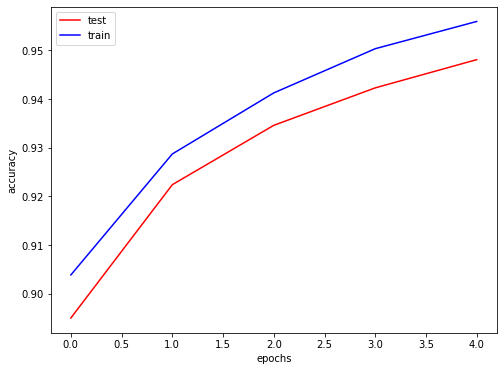

In [6]:
# code for the plots:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
plt.plot(range(5), nn.accuracy, c='red')
plt.xlabel('epochs')
plt.ylabel('accuracy')

plt.plot(range(5), nn_train.accuracy, c='blue')
plt.xlabel('epochs')
plt.ylabel('accuracy')

plt.legend(['test', 'train'])

plt.show()